## Setup environment

Note the hollow bars test image used in this example was developed by the Biomedical Imaging Group at EPFL and can be found [here](http://bigwww.epfl.ch/deconvolution/bars/).

To run deconvolution examples, we recommend setting up an environment as follows, please post to [Image.sc](https://forum.image.sc/) if you have any issues setting up the environment and/or running the example. 

    conda create --name decon-env python=3.9
    conda activate decon-env
    conda install -c conda-forge jupyterlab
    conda install -c conda-forge pyopencl==2021.2.6 hdbscan numba=0.55.1
    pip install devbio-napari
    
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft
    pip install stardist
    
Mac-users please also install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users please also install this:

    conda install -c conda-forge ocl-icd-system


## Get and open test images

1.  Get the tnia-python-images image collection https://www.dropbox.com/scl/fo/ir7g1bz4w0bbjbskbq5ng/h?dl=0&rlkey=zdbven69fvd60za8wt49fd0w9
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder
3.  Use imread to verify you can open the image, then print the size of the image and verify it is is ```(128,256,256)```


In [1]:
from skimage.io import imread

im_path=r"D:\images\tnia-python-images\deconvolution\bars\\"
im_name='Bars-G10-P15-stack.tif'
psf_name='PSF-Bars-stack.tif'
truth_name='Bars-stack.tif'

im=imread(im_path+im_name)
psf=imread(im_path+psf_name)
truth=imread(im_path+truth_name)
im=im.astype('float32')

# normalize the PSF so that PSF energy is 1
psf=psf.astype('float32')
psf=psf/psf.sum()

# We also need to make sure the 'truth' and 'imaged' images have the same sum intensity (for some reason they do not).
truth=truth*(im.sum()/truth.sum())
print(im.sum())
print(truth.sum())
print(im.shape, psf.shape, truth.shape)

29587579000.0
29587578880.0
(128, 256, 256) (128, 256, 256) (128, 256, 256)


## View 3D Data in notebook

View the data using xy, xz, and zy max projections.  

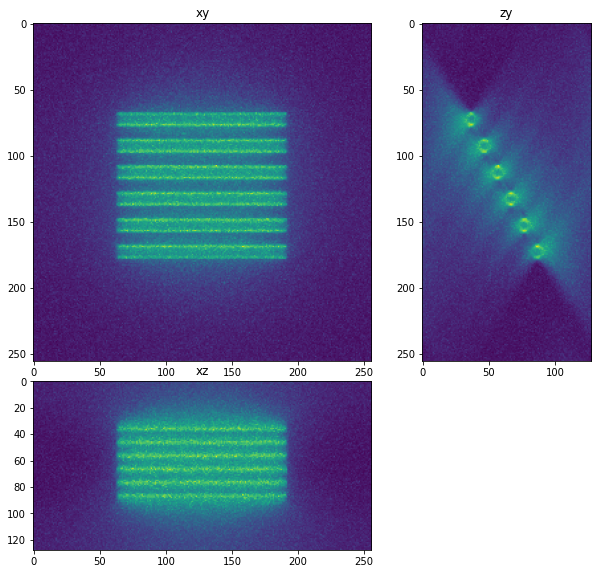

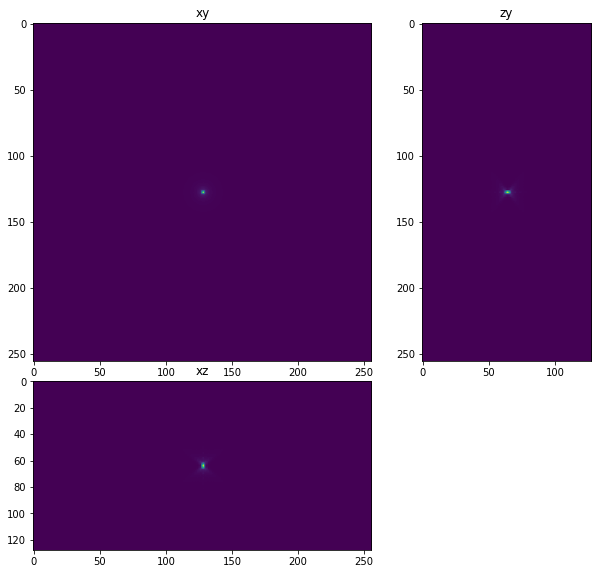

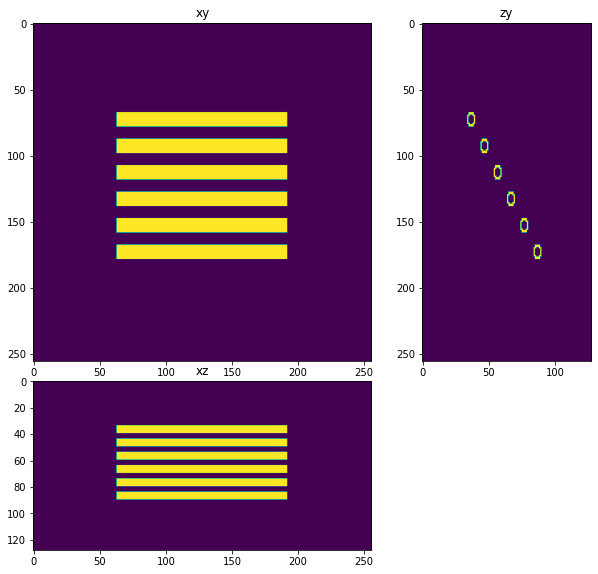

In [2]:
from tnia.plotting.projections import show_xyz_max, show_xyz_slice

fig=show_xyz_max(im)
fig=show_xyz_max(psf)
fig=show_xyz_max(truth)


## Import deconvolution libraries

Try imnporting the clij2 and redlionfish implementations of Richardson Lucy.  If they are found perform a deconvolution with each library

In [3]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc
    clij2_rl_found=True
    
except ImportError:
    clij2_rl_found=False
try:
    import RedLionfishDeconv as rl
    redlionfish_rl_found=True
except ImportError:
    redlionfish_rl_found=False
    
print('clij2 rl found',clij2_rl_found)
print('redlionfish rl found',redlionfish_rl_found)    

clij2 rl found True
redlionfish rl found True


## Deconvolve and visualize in notebook

get lib
get lib


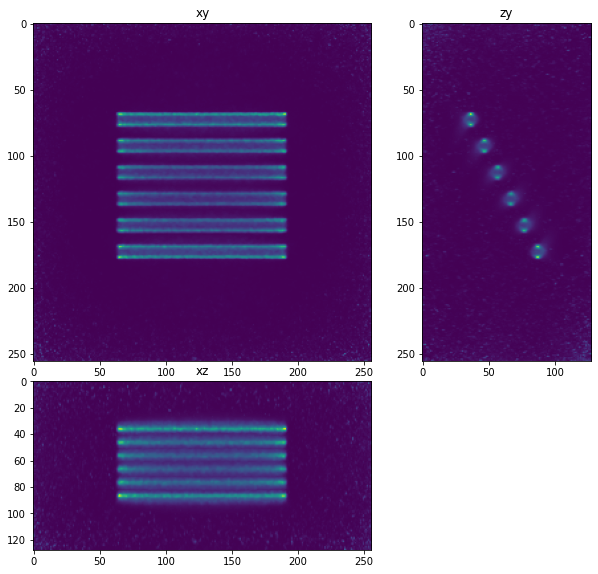

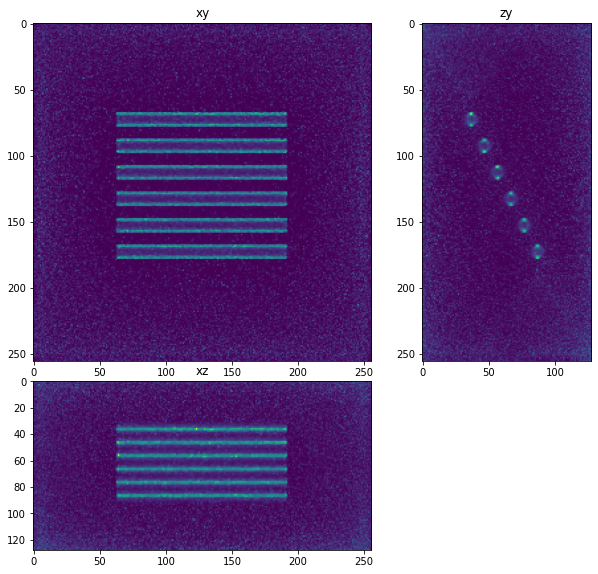

In [5]:
decon100=richardson_lucy_nc(im,psf,100,0.0002)
decon1000=richardson_lucy_nc(im,psf,1000,0.0002)

fig=show_xyz_max(decon100)
fig=show_xyz_max(decon1000)

## Try different combinations of number iterations and regularization factor

Try different parameters and see if changing the number of iterations and/or the regularization factor improves the rmse.

In [8]:
from tnia.metrics.errors import RMSE

regularization_factor=[0, 0.0001, 0.0005, 0.001]
iterations = [100, 1000, 2000]

decons=[]

for rf in regularization_factor:
    for it in iterations:
        decon=richardson_lucy_nc(im,psf,it,rf)
        temp=[rf, it, decon]
        decons.append(temp)
        rmse=RMSE(truth, decon)
        print('iterations',it,'regularization factor',rf,'RMSE',rmse)


get lib
iterations 100 regularization factor 0 RMSE 51918.852802485
get lib
iterations 1000 regularization factor 0 RMSE 47045.924593316995
get lib
iterations 2000 regularization factor 0 RMSE 49482.65525054975
get lib
iterations 100 regularization factor 0.0001 RMSE 51960.09158616968
get lib
iterations 1000 regularization factor 0.0001 RMSE 46342.468940134684
get lib
iterations 2000 regularization factor 0.0001 RMSE 47605.15930794511
get lib
iterations 100 regularization factor 0.0005 RMSE 52127.68540600777
get lib
iterations 1000 regularization factor 0.0005 RMSE 45686.463951152415
get lib
iterations 2000 regularization factor 0.0005 RMSE 46311.71472869601
get lib
iterations 100 regularization factor 0.001 RMSE 52325.13472013442
get lib
iterations 1000 regularization factor 0.001 RMSE 45881.796479861354
get lib
iterations 2000 regularization factor 0.001 RMSE 46042.07447352516


## Plot results in table

Here we plot the results using different number of iterations and different regularization factor in a table.  We look closely at the YZ slice projection of 2 of the bars to evaluate how well the hollow bar was reconstructed.  

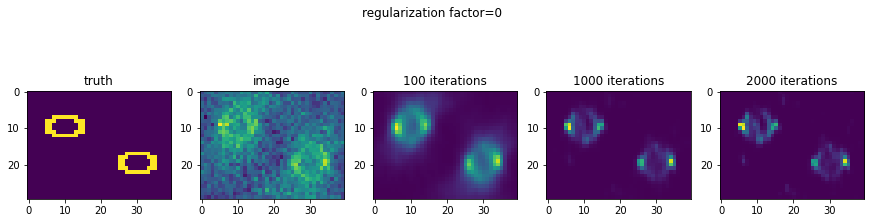

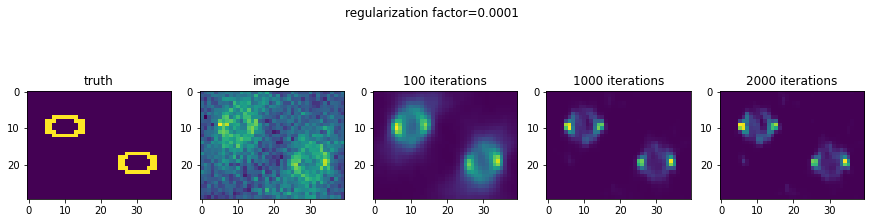

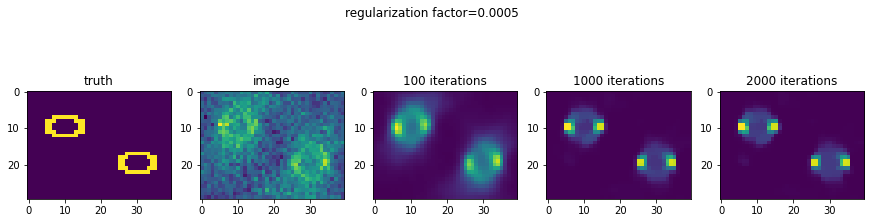

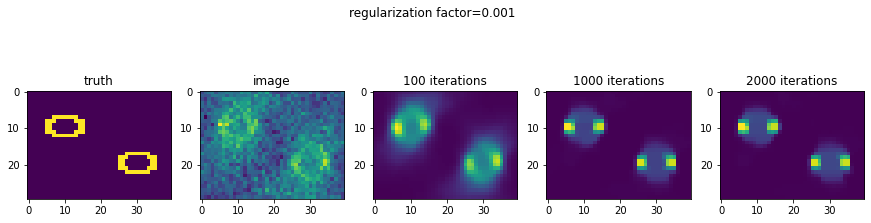

In [11]:
import numpy as np
from tnia.plotting.plt_helper import imshow_multi2d

len(decons)
ind = np.s_[47:77, 103:143, 110]
n=0
for rf in regularization_factor:
    decons_=[]
    titles=[]
    decons_.append(truth[ind])
    titles.append('truth')
    decons_.append(im[ind])
    titles.append('image')
    for it in iterations:
        decons_.append(decons[n][2][ind])
        rmse=RMSE(truth,decons[n][2])
        titles.append(str(decons[n][1])+' iterations')
        n=n+1
    #print('regularization factor='+str(rf))
    fig = imshow_multi2d(decons_, titles, 1, 5, 15)
    fig.suptitle('regularization factor='+str(rf))

## Deconvolve with redlionfish library

This is an alternative Richardson Lucy implementation.  

ERROR:root:Failed to setup Reikna with OpenCL.
ERROR:root:No module named 'reikna'


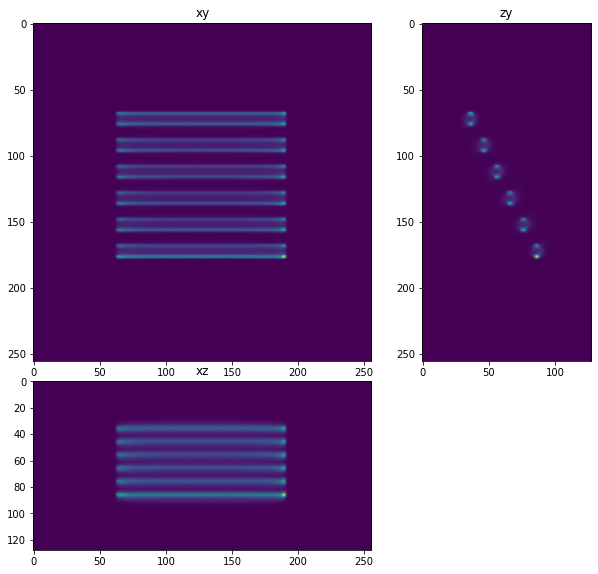

In [5]:
if redlionfish_rl_found==True:
    decon_rlf=rl.doRLDeconvolutionFromNpArrays(im, psf, niter=100, method='gpu', resAsUint8=False )
    fig=show_xyz_max(decon_rlf)

## View data in Napari and ask questions

View the data in Napari, switch to a 3D view and rotate and explore the dataset?  How good is the reconstruction?  Is it a truer representation of the data as compared to the image?  

Excercise: Deconvolve the data for 1000 iterations, or 10,000 if you have a fast GPU (or even 100,000 if you have a fast GPU and a bit of time).  Does the reconstruction continue to improve with more iterations?

In [12]:
import napari
viewer=napari.Viewer()
viewer.add_image(im)
viewer.add_image(decon100)
viewer.add_image(decon1000)
#viewer.add_image(decon_rlf)
viewer.add_image(truth)

C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 623, in ru

<Image layer 'truth' at 0x1ba79880e50>